# Image postprocessing of Refrigerant sprays

This program takes images of Refrigerant sprays and obtains extinction profiles.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2020 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 15/02/2022
        __   ____________    ___    ______
       / /  /_  ____ __  \  /   |  / ____/
      / /    / /   / /_/ / / /| | / /
     / /___ / /   / _, _/ / ___ |/ /_________
    /_____//_/   /_/ |__\/_/  |_|\__________/

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia



In [49]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import glob, sys, os
import matplotlib.pyplot as plt
from scipy.interpolate import interp2d
import scipy.integrate, scipy.signal
from joblib import Parallel, delayed
%matplotlib notebook

In [1]:
# Define where images come from.
srcdir = "/Users/dduke/Desktop"
source_images = srcdir+"/nz013_r134a_01.raw"
source_bkgnd  = srcdir+"/nz013_r134a_01bk.raw"

In [69]:
# Read in images.
B=ImageSequence(source_bkgnd,rawtype='chronos14_mono_12bit',width=1280,height=1024)
print("")
I=ImageSequence(source_images,rawtype='chronos14_mono_12bit',width=1280,height=1024, IO_threads=4, frames=(0,2000))

Reading /Users/dduke/Desktop/nz013_r134a_01bk.raw
Chronos 12-bit RAW
File contains 11 frames (1280 x 1024)
Read 20.0 MiB in 0.3 sec
	Data in memory:	 (11, 1024, 1280)
	Intensity range:	 0 to 348 	 uint16
	Array size:	27.5 MB

Reading /Users/dduke/Desktop/nz013_r134a_01.raw
Chronos 12-bit RAW
File contains 8733 frames (1280 x 1024)
Reading frames 0 to 2000
Read 3750.0 MiB in 60.7 sec
	Data in memory:	 (2000, 1024, 1280)
	Intensity range:	 0 to 2056 	 uint16
	Array size:	5000.0 MB


In [42]:
# apply crop
#B.crop(107,107+304,85,85+915)
#I.crop(107,107+304,85,85+915)
#print('\nFinal array sizes:', B.shape(), I.shape())

# Mask unwanted portions of image
#B.mask_box(268,305,903,916)
#B.mask_box(0,42,903,916)

# apply flip
#B.fliph()
#I.fliph()

In [70]:
# Remove background, put into array Ib
Ib = np.zeros_like(I.arr,dtype=np.float32)
bkgnd = np.nanmean(B.arr.astype(np.float32),axis=0)
bkgnd[bkgnd<=0] = np.nan
for n in range(I.N):
    Ib[n,...] = I.arr[n,...] / bkgnd
    
# Clip value range
Ib[Ib<-0.5]=-0.5
Ib[Ib>1.5]=1.5
    
# Convert transmission to extinction
Ib = 1.0 - Ib

# Get co-ordinates
y = np.arange(Ib.shape[1])
x = np.arange(Ib.shape[2])
t = np.arange(Ib.shape[0])

In [ ]:
plt.rcParams["figure.figsize"] = (10, 6)

# Show some samples
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
ax=fig.add_subplot(221)
h=ax.imshow(Ib[1,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h)
ax=fig.add_subplot(222)
h=ax.imshow(Ib[int(I.N/3),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(223)
h=ax.imshow(Ib[int(I.N*2/3),...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);
ax=fig.add_subplot(224)
h=ax.imshow(Ib[I.N-1,...],cmap=plt.cm.gray,vmin=0,vmax=1)
plt.colorbar(h);

## Classify sprays based on extinction near nozzle

<IPython.core.display.Javascript object>


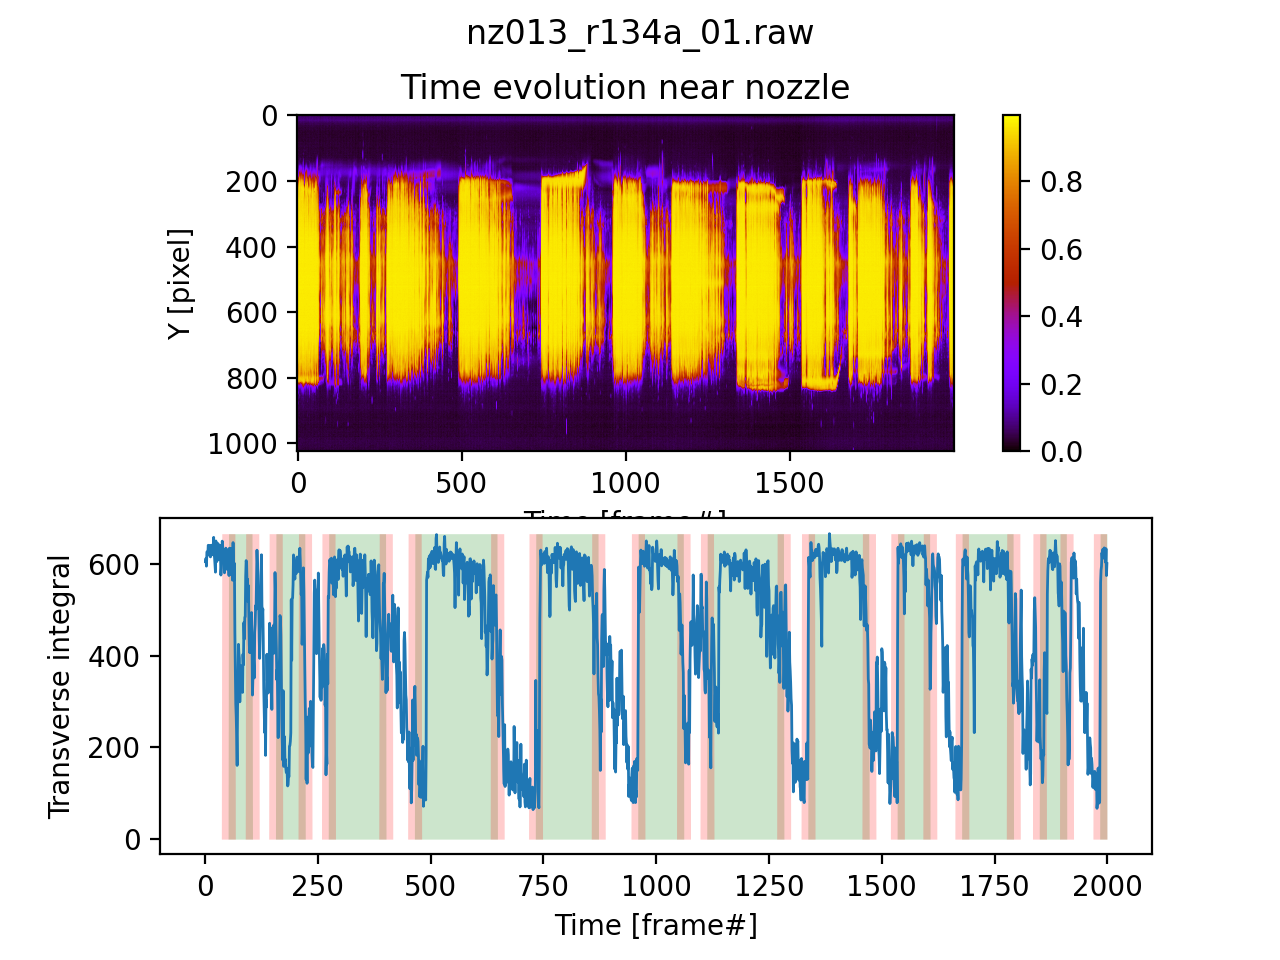

In [105]:
# Reslice near the nozzle to see time evolution
# Average over several X positions.
near_nozzle_profiles = np.nanmean(Ib[...,100:125],axis=-1).T
near_nozzle_integral = scipy.integrate.simps(near_nozzle_profiles.T,x=y,axis=-1)
near_nozzle_integral[0]=np.nan

# Use the integral to find the time where the spray extinction is high.
threshold = 0.5 # higher value means less time samples but lower std dev.
on = near_nozzle_integral > threshold*np.nanmax(near_nozzle_integral)

# Smooth the 'on' threshold so that each region must be >= 50 frames in duration.
j=0
for i in range(1,len(on)):
    if on[i-1]==on[i]: j+=1
    elif j<=50:
        j+=1
        on[i]=on[i-1]
    else:
        j=0
        
# Transitional region +-10 frames either side of mode transition.
don = np.hstack((0,np.diff(on)))
trans = np.abs(don)
for i in range(10,len(don)-10):
    if don[i]!=0:
        trans[i-15:i+15]=1

# Show the time evolution near the nozzle
fig=plt.figure()
plt.suptitle(os.path.basename(source_images))
ax=fig.add_subplot(211)
plt.title("Time evolution near nozzle")
plt.ylabel("Y [pixel]")
plt.xlabel("Time [frame#]")
h=ax.imshow(near_nozzle_profiles, cmap=plt.cm.gnuplot,vmin=0)
plt.colorbar(h)
ax=fig.add_subplot(212)
ax.plot(t, near_nozzle_integral, lw=1)
plt.ylabel("Transverse integral")
plt.xlabel("Time [frame#]");
ax.fill_between(t,0*on,np.nanmax(near_nozzle_integral)*on,lw=0,alpha=.2,color='g')
ax.fill_between(t,0*trans,np.nanmax(near_nozzle_integral)*trans,lw=0,alpha=.2,color='r');


## Steady state statistics

In [106]:
# Take mean & std dev over all the data
Im0 = np.nanmean(Ib,axis=0)
Is0 = np.nanstd(Ib,axis=0)

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_51797/1529183211.py:2: RuntimeWarning: Mean of empty slice
  Im0 = np.nanmean(Ib,axis=0)
/usr/local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [107]:
# Take mean & std dev over liquid-only period
Im1 = np.nanmean(Ib[on,...],axis=0)
Is1 = np.nanstd(Ib[on,...],axis=0)

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_51797/147262359.py:2: RuntimeWarning: Mean of empty slice
  Im1 = np.nanmean(Ib[on,...],axis=0)


In [108]:
# Take mean & std dev over vapour-dominated period
Im2 = np.nanmean(Ib[~on,...],axis=0)
Is2 = np.nanstd(Ib[~on,...],axis=0)

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_51797/3436676817.py:2: RuntimeWarning: Mean of empty slice
  Im2 = np.nanmean(Ib[~on,...],axis=0)


In [ ]:
# Take mean & std dev over transitory period
Im3 = np.nanmean(Ib[trans,...],axis=0)
Is3 = np.nanstd(Ib[trans,...],axis=0)

/var/folders/6z/v83wfyrn4pqdkbl08lfx_pgmvzd0gj/T/ipykernel_51797/2571031102.py:2: RuntimeWarning: Mean of empty slice
  Im3 = np.nanmean(Ib[trans,...],axis=0)


In [ ]:
# Plot mean and std dev profiles
fig=plt.figure()
ax=fig.add_subplot(421)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - all data")
h=ax.imshow(Im0,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(422)
plt.title("Std. Dev. - all data")
h=ax.imshow(Is0,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h);

ax=fig.add_subplot(423)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - liquid dominated flow")
h=ax.imshow(Im1,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(424)
plt.title("Std. Dev. - liquid dominated flow")
h=ax.imshow(Is1,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h);

ax=fig.add_subplot(425)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - Vapour dominated flow")
h=ax.imshow(Im2,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(426)
plt.title("Std. Dev. - Vapour dominated flow")
h=ax.imshow(Is2,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h);

ax=fig.add_subplot(427)
plt.suptitle(os.path.basename(source_images))
plt.title("Mean - Transitional flow")
h=ax.imshow(Im2,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h)

ax=fig.add_subplot(428)
plt.title("Std. Dev. - Transitional flow")
h=ax.imshow(Is2,cmap=plt.cm.jet)
#ax.plot(x, centerline(x), c='w', lw=1, ls='--', alpha=.8)
plt.colorbar(h);